Hey

In [1]:
import pandas as pd
import lightgbm as ltb
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5



In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

In [3]:
# data_traff = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/train/hash_school_dpi_model_traff.sas7bdat')
# data = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/train/hash_school_dpi_model_fe.sas7bdat')


In [4]:
data_traff = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/train/hash_school_dpi_model_traff.sas7bdat')
data = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/train/hash_school_dpi_model_fe.sas7bdat')


In [5]:
print(data.shape)
print(data_traff.shape)
data_traff = data_traff.drop_duplicates()
data = data.drop_duplicates()
print(data.shape)
print(data_traff.shape)

(250043, 906)
(249967, 6)
(250026, 906)
(249955, 6)


In [6]:
# test_data_traff = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_traff_test.sas7bdat')
# test_data = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_fe_test.sas7bdat')
# print(test_data.shape)
# print(test_data_traff.shape)

In [7]:
# data_traff_unique = data_traff.abon_id.value_counts()
# duplicates_data_traff = data_traff_unique[data_traff_unique > 1].index.to_list()
# data_traff.loc[data_traff['abon_id'].isin(duplicates_data_traff)].sort_values(by = 'abon_id')

In [8]:
data = data.merge(data_traff, on = 'abon_id')
del data_traff

In [9]:
# describe_data = data.describe()
# describe_data.head()
#print(data.isnull().sum().sort_values(ascending = False))
#print(data.isnull().sum().sort_values(ascending = False)/data['abon_id'].size)

In [10]:
columns_nulls_less_60p = data.columns[(data.isnull().sum()/data['abon_id'].size) < 0.6]
print(columns_nulls_less_60p.shape)
data_nulls_less_60p = data[columns_nulls_less_60p]
data_nulls_less_60p.shape
del data

(780,)


In [11]:
def mark_outliers(df, cols, outlier_coeff = 1.5): 
    outliers_mask = df.copy()
    counter = 1
    for col in cols:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        if (counter%100 == 0):
            print(counter)
        counter += 1
    return outliers_mask        
        
# test = pd.DataFrame(data = np.array([1,2,5,100,2,5,1000]), columns = ['test'])
# mark_outliers(test, test)

In [12]:
data_nulls_less_60p_outliers_mask = mark_outliers(data_nulls_less_60p, data_nulls_less_60p.columns)

100
200
300
400
500
600
700


In [199]:
def univalue_feauture_info (df, cols, outliers_mask_df):
    
    univalue_feauture_info_df = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', 'if_cat', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in cols:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        univalue_feauture_info_df = univalue_feauture_info_df.append({'col': col, \
                                                                      '%of_fr_univalue': freq_value_count,\
                                                                      '%of_unfr_univalue': unfreq_value_count,\
                                                                      'if_cat': if_cat,\
                                                                      '%outliers': perc_outl,\
                                                                      '%nans': perc_nans,\
                                                                      'freq_value': freq_value},\
                                                                      ignore_index=True)
        
    return univalue_feauture_info_df.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False)   

# data_nulls_less_60p_temp_mask = mark_outliers(data_nulls_less_60p, ['Balance_uah', 'CALCULATION_METHOD_ID', 'device_brand_other'])
# temp = univalue_feauture_info(data_nulls_less_60p, ['Balance_uah', 'CALCULATION_METHOD_ID', 'device_brand_other'],data_nulls_less_60p_temp_mask)
# temp

In [200]:
univalue_cols = univalue_feauture_info(data_nulls_less_60p, data_nulls_less_60p.columns, data_nulls_less_60p_outliers_mask)

In [201]:
def highlight_p75(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s >= s.quantile(0.75)
    return ['background-color: yellow' if v else '' for v in is_max]

In [204]:
cat_cols = univalue_cols[univalue_cols['if_cat'] == 1]
num_cols = univalue_cols[univalue_cols['if_cat'] == 0]

univalue_cols_style = cat_cols.style.apply(highlight_p75, subset=['%outliers', '%nans']).format({'%of_fr_univalue': "{:.2%}",'%of_unfr_univalue': "{:.2%}",'%outliers': "{:.2%}",'%nans': "{:.2%}"})
univalue_cols_style

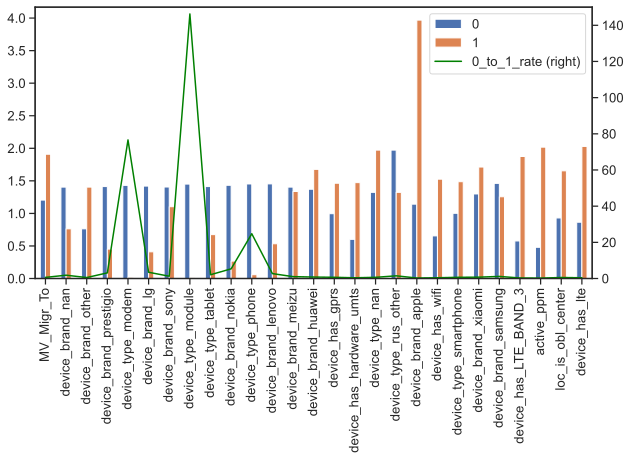

In [179]:
cat_cols_list = cat_cols['col'].tolist()
target_by_cat_cols = pd.DataFrame(index=cat_cols_list, columns=['0', '1', '0_to_1_rate'])

for col in cat_cols_list:
    temp = data_nulls_less_60p.pivot_table(columns=col,values='target', aggfunc='median').fillna(0).applymap(float)
#     print(temp.values[0][0])
    target_by_cat_cols.loc[col]['0'] = temp.values[0][0]
    target_by_cat_cols.loc[col]['1'] = temp.values[0][1]
    target_by_cat_cols.loc[col]['0_to_1_rate'] = temp.values[0][0]/temp.values[0][1]

width = .35
    
ax1 = target_by_cat_cols.loc[:, ['0', '1']].plot(kind = 'bar', figsize = (10,5), rot = 90);
ax2 = target_by_cat_cols['0_to_1_rate'].plot(secondary_y=True, colormap = 'ocean', rot = 90, legend = True);
ax2.set_ylim(0, 150);


In [170]:
target_by_cat_cols

0           1 0_to_1_rate
MV_Migr_To                 1.20474     1.90877    0.631161
device_brand_nan           1.40387    0.762984     1.83997
device_brand_other        0.762984     1.40387    0.543486
device_brand_prestigio     1.41214    0.451645     3.12665
device_type_modem          1.43022   0.0186704     76.6037
device_brand_lg            1.41947    0.410003     3.46209
device_brand_sony          1.40532      1.1026     1.27455
device_type_module         1.45016  0.00991631      146.24
device_type_tablet         1.41199    0.673647     2.09604
device_brand_nokia         1.43174    0.267215     5.35801
device_type_phone          1.45187   0.0586423     24.7581
device_brand_lenovo        1.45313    0.533938     2.72154
device_brand_meizu         1.40353     1.33605     1.05051
device_brand_huawei        1.37097     1.67673    0.817647
device_has_gprs           0.995223     1.46314    0.680196
device_has_hardware_umts  0.601686     1.47313     0.40844
device_type_nan            1.32318     1.97219    0.670921
device_type_rus_other      1.97219     1.32318     1.49049
device_brand_apple         1.14232     3.96857    0.287842
device_has_wifi           0.654362      1.5256     0.42892
device_type_smartphone     1.00122     1.48714    0.673248
device_brand_xiaomi        1.29853     1.71213    0.758428
device_brand_samsung       1.46114     1.25566     1.16365
device_has_LTE_BAND_3      0.57689     1.87403    0.307834
active_ppm                0.479359     2.01747    0.237604
loc_is_obl_center         0.930542     1.65423    0.562521
device_has_lte            0.864738     2.02882    0.426226

In [89]:
data_nulls_less_60p.pivot_table(columns=cat_cols_list[1],values='target', aggfunc='mean').fillna(0).applymap(float)

device_brand_nan       0.0       1.0
target            5.980966  5.473336

In [71]:
plt.close('all')

(27, 6)


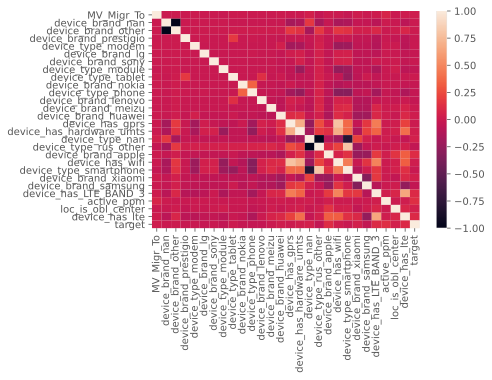

In [14]:
print(cat_cols.shape)
cols = cat_cols['col'].tolist()
cols.append('target')
hm = sns.heatmap(data_nulls_less_60p[cols].corr(), cbar=True, annot=False, xticklabels=True, yticklabels=True)


In [72]:
device_type_cols = cat_cols[cat_cols['col'].str.contains('device_type')]['col'].tolist()
cat_data_for_plot = data_nulls_less_60p[device_type_cols+['target']]
new = cat_data_for_plot.groupby(device_type_cols).agg({'target' : ['mean','count', 'median']})
#cat_data_for_plot.groupby(device_type_cols)[['target']].mean()



In [103]:
data_nulls_less_60p.columns

Index(['abon_id', 'Balance_uah', 'TM_ID', 'lt', 'CALCULATION_METHOD_ID',
       'device_days_usage', 'device_brand_samsung', 'device_brand_nokia',
       'device_brand_lenovo', 'device_brand_apple', 'device_brand_huawei',
       'device_brand_lg', 'device_brand_xiaomi', 'device_brand_meizu',
       'device_brand_prestigio', 'device_brand_sony', 'device_brand_nan',
       'device_brand_other', 'device_has_gprs', 'device_has_wifi',
       'device_has_lte', 'device_type_modem', 'device_type_module',
       'device_type_phone', 'device_type_smartphone', 'device_type_tablet',
       'device_type_nan', 'device_type_rus_other', 'device_sim_count',
       'device_price', 'loc_cnt_events', 'loc_is_obl_center', 'loc_lat',
       'loc_lon', 'loc_market_share', 'bs_of_succ_but_drop_m1',
       'bs_of_succ_m1', 'bs_of_unsucc_attemp_equip_m1',
       'bs_of_unsucc_low_balance_m1', 'bs_of_attemps_all_m1',
       'bs_of_recall_m1', 'bs_succ_rate', 'bs_drop_call_rate', 'bs_drop_rate',
       'bs_recall

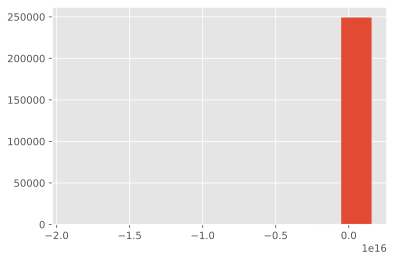

In [104]:
data_nulls_less_60p['Balance_uah'].hist()

In [99]:
temp = cat_data_for_plot.groupby('device_type_tablet').agg({'target' : ['mean','median']})
temp.index


Float64Index([0.0, 1.0], dtype='float64', name='device_type_tablet')

In [ ]:
fig, axs = plt.subplots(len(device_type_cols))
fig.suptitle('Target stats by device type')

counter = 0
for col in device_type_cols:
    temp = cat_data_for_plot.groupby(col).agg({'target' : ['mean','median']})
    axs[counter].plot(x, y)
    axs[1].plot(x, -y)

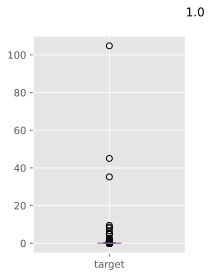

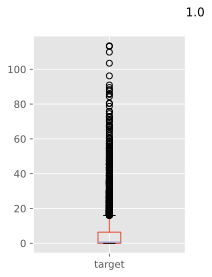

In [82]:
for col in temp:
    for title, group in cat_data_for_plot.groupby(col):
        group.plot(kind = 'box', x = col, y = 'target', title = title, subplots = True, sharex = True, sharey = True, \
                  layout = (1,2))

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data_nulls_less_60p)
data_nulls_less_60p_normalized = pd.DataFrame(x_scaled)
data_nulls_less_60p_normalized.columns = data_nulls_less_60p.columns
data_nulls_less_60p_normalized.head()

In [ ]:
data_nulls_less_60p[data_nulls_less_60p['target']== 0].shape[0]/data_nulls_less_60p.shape[0]


In [105]:
data_nulls_less_60p.head()

abon_id   Balance_uah      TM_ID        lt  CALCULATION_METHOD_ID  \
0  1000004.0  1.420369e+00  72.014152  4.536151                    1.0   
1  1000008.0  7.953525e+00  72.003644  4.537497                    1.0   
2  1000011.0  2.848294e-01  72.205782  4.552167                    1.0   
3  1000013.0  6.433818e-09  71.714189  4.537721                    1.0   
4  1000014.0  3.447618e+00  72.014152  4.564179                    1.0   

   device_days_usage  device_brand_samsung  device_brand_nokia  \
0           7.687248                   0.0                 0.0   
1          38.843408                   0.0                 0.0   
2          36.455885                   0.0                 0.0   
3          34.481767                   0.0                 0.0   
4           5.749902                   0.0                 0.0   

   device_brand_lenovo  device_brand_apple  device_brand_huawei  \
0                  0.0                 0.0                  1.0   
1                  0.0                 0.0                  1.0   
2                  1.0                 0.0                  0.0   
3                  0.0                 0.0                  0.0   
4                  0.0                 0.0                  0.0   

   device_brand_lg  device_brand_xiaomi  device_brand_meizu  \
0              0.0                  0.0                 0.0   
1              0.0                  0.0                 0.0   
2              0.0                  0.0                 0.0   
3              0.0                  0.0                 0.0   
4              0.0                  1.0                 0.0   

   device_brand_prestigio  device_brand_sony  device_brand_nan  \
0                     0.0                0.0               0.0   
1                     0.0                0.0               0.0   
2                     0.0                0.0               0.0   
3                     0.0                0.0               0.0   
4                     0.0                0.0               0.0   

   device_brand_other  device_has_gprs  device_has_wifi  device_has_lte  \
0                 1.0              1.0              1.0             1.0   
1                 1.0              1.0              1.0             1.0   
2                 1.0              1.0              1.0             0.0   
3                 1.0              0.0              0.0             0.0   
4                 1.0              0.0              0.0             0.0   

   device_type_modem  device_type_module  device_type_phone  \
0                0.0                 0.0                0.0   
1                0.0                 0.0                0.0   
2                0.0                 0.0                0.0   
3                0.0                 0.0                0.0   
4                0.0                 0.0                0.0   

   device_type_smartphone  device_type_tablet  device_type_nan  \
0                     0.0                 0.0              1.0   
1                     1.0                 0.0              0.0   
2                     1.0                 0.0              0.0   
3                     1.0                 0.0              0.0   
4                     0.0                 0.0              1.0   

   device_type_rus_other  device_sim_count  device_price  loc_cnt_events  \
0                    0.0               NaN           NaN           428.0   
1                    1.0               2.0         290.0           546.0   
2                    1.0               2.0         140.0           541.0   
3                    1.0               1.0         100.0            83.0   
4                    0.0               NaN           NaN           835.0   

   loc_is_obl_center    loc_lat    loc_lon  loc_market_share  \
0                0.0  15.363497  11.537250          1.498606   
1                1.0  15.445647  12.599885          0.337849   
2                1.0  15.238678  12.546138          0.379457   
3                0.0  14.816514  12.044341  

In [106]:
data_nulls_less_60p['MV_DOU_PPM_VF'].sort_values(ascending=False).head(100)
    

154466    17.033238
182370    17.033238
214110    17.033238
102559    17.033238
215199    17.033238
215195    17.033238
204901    17.033238
13635     17.033238
220163    17.033238
216830    17.033238
212327    17.033238
215968    17.033238
216512    17.033238
154474    17.033238
154473    17.033238
205820    17.033238
211553    17.033238
154468    17.033238
182339    17.033238
212314    17.033238
212888    17.033238
219230    17.033238
209164    17.033238
205862    17.033238
204916    17.033238
185853    17.033238
215227    17.033238
222779    17.033238
154515    17.033238
209505    17.033238
98450     17.033238
154510    17.033238
206516    17.033238
215947    17.033238
30763     17.033238
171231    17.033238
208534    17.033238
170142    17.033238
208536    17.033238
206512    17.033238
184647    17.033238
172538    17.033238
212908    17.033238
174753    17.033238
72526     17.033238
185408    17.033238
207046    17.033238
222012    17.033238
204430    17.033238
213673    17.033238


In [ ]:
data_nulls_less_60p['Balance_uah'].loc[~data_nulls_less_60p_outliers_mask['Balance_uah']].hist()

In [ ]:
# df_length = data_nulls_less_60p.shape[0]
# IQR = data_nulls_less_60p['Balance_uah'].quantile(0.75) - data_nulls_less_60p['Balance_uah'].quantile(0.25)
# IQR_index = 1.5
print("{0:.5f}%".format(data_nulls_less_60p['Balance_uah'].isnull().sum()/df_length))
print(data_nulls_less_60p['Balance_uah'].value_counts().sort_values(ascending = False)[0])
print("{0:.5f}%".format(data_nulls_less_60p['Balance_uah'].value_counts().sort_values(ascending = False).iloc[0]/df_length))
print(data_nulls_less_60p['Balance_uah'].describe())



In [ ]:
data_nulls_less_60p['Balance_uah'].plot.box()

In [ ]:
data_nulls_less_60p['Balance_uah'].describe()
data_nulls_less_60p['Balance_uah'].hist()

In [ ]:
# #traff data turn to negatives in comarison with where target is not zero

# describe_data = describe_data[columns_nulls_less_60p]
# describe_data_nulls_less_60p_target0 = data_nulls_less_60p[data_nulls_less_60p['target']== 0].describe()
# describe_data_nulls_less_60p_target0.sub(describe_data)


# stats_comp = describe_data_nulls_less_60p_target0.iloc[[1,5], :].sub(describe_data.iloc[[1,5], :]). \
#     divide(describe_data_nulls_less_60p_target0.iloc[[1,5], :]).transpose()
# stats_comp.head()

# stats_comp.sort_values(by = '50%').style.format({'mean' : '{:,.2f}', '50%' : '{:,.2f}'})

# p25 = data_nulls_less_60p['non_accum_internet_vol_max_mnt1'].describe()['25%']
# p75 = data_nulls_less_60p['non_accum_internet_vol_max_mnt1'].describe()['75%']
# p50 = data_nulls_less_60p['non_accum_internet_vol_max_mnt1'].describe()['50%']
# pmax = data_nulls_less_60p['non_accum_internet_vol_max_mnt1'].describe()['max']
# #data_nulls_less_60p['non_accum_internet_vol_max_mnt1'].describe()
# #data_nulls_less_60p[data_nulls_less_60p['non_accum_internet_vol_max_mnt1'] == 0].shape

# #data_nulls_less_60p['non_accum_internet_vol_max_mnt1'].sort_values(ascending = False).head()
# (data_nulls_less_60p['non_accum_internet_vol_max_mnt1'] != 0).sum()


In [ ]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('Target')
sns.boxplot(ax = axes[0], data = data_nulls_less_60p, x = 'target', orient = 'v' )
sns.distplot(ax = axes[1], a = data_nulls_less_60p['target'])


print(data_nulls_less_60p['target'].describe())

In [ ]:
# p75_target  = data_nulls_less_60p['target'].describe()['75%']
# #data_nulls_less_60p[data_nulls_less_60p['target'] < p75_target]['target'].hist()
# data_nulls_less_60p.sort_values(by = 'target', ascending = False)['target'].head(1000)

In [ ]:
sns.distplot?

In [ ]:
cols = ['target', 'traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
hm = sns.heatmap(data[cols].corr(), cbar=True, annot=True)

In [ ]:
serv_add_4or2GB


In [ ]:
# X, y = data.loc[:, data.columns != 'target'], data.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

In [ ]:
cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
X, y = data_nulls_less_60p[cols_traff_only], data_nulls_less_60p.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

In [ ]:
slr = LinearRegression()

slr.fit(X_train, y_train)

print('Slope: {:.2f}'.format(slr.coef_[0]))
print('Intercept: {:.2f}'.format(slr.intercept_))

y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [ ]:
print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train, y_train_pred, squared = False),
        mean_squared_error(y_test, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

In [ ]:
cols_traff_only = ['traff_m5', 'traff_m3', 'traff_m2', 'traff_m1']
X, y = data_nulls_less_60p[cols_traff_only], data_nulls_less_60p.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

slr = LinearRegression()

slr.fit(X_train, y_train)

print('Slope: {:.2f}'.format(slr.coef_[0]))
print('Intercept: {:.2f}'.format(slr.intercept_))

y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train, y_train_pred, squared = False),
        mean_squared_error(y_test, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y.values.reshape(-1, 1)).flatten()
# newaxis увеличивает размерность массива, flatten — наооборот
# https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#numpy.newaxis
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.flatten.html

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_std, y_std, test_size=0.3, random_state=0)

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train_scaled)
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)
print(lasso.coef_)

print('RMSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train_scaled, y_train_pred, squared = False),
        mean_squared_error(y_test_scaled, y_test_pred, squared = False)))
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train_scaled, y_train_pred),
        r2_score(y_test_scaled, y_test_pred)))

In [ ]:
data['target'].describe()

In [ ]:
# model = ltb.LGBMRegressor()
# model.fit(X_train, y_train)
# print(); print(model)

# expected_y  = y_test
# predicted_y = model.predict(X_test)


In [ ]:
print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_squared_error(expected_y, predicted_y))

In [ ]:
#closs_val_score(model, X, y ... )
#from skearn.model_selection import GridSearchCV